In [108]:
import numpy as np
import os,glob,struct
import xarray as xr
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [113]:
from parflow import Run
from parflow.tools.fs import exists, chdir, mkdir, cp, rm
import os,shutil,copy

In [114]:
root_dir = "/home/hectorb/PARFLOW/PROJECTS/Hillslope/ASAO_sensitivity/"

In [115]:
hill = Run.from_definition(root_dir+'hillslope_sens.pfidb')

In [116]:
def PFB_read(pfb_file_path, flag):

    #print("**This code DOES handle subgrids**")
    # flag = 1: return array + header
    # flag = 0: return array only
    
    hdr_dict = {}
    
    with open(pfb_file_path,'rb') as pfbf:
        hdr_dict['X0'] = struct.unpack('>d', pfbf.read(8))[0]
        hdr_dict['Y0'] = struct.unpack('>d', pfbf.read(8))[0]
        hdr_dict['Z0'] = struct.unpack('>d', pfbf.read(8))[0]
        hdr_dict['nx'] = struct.unpack('>i', pfbf.read(4))[0]
        hdr_dict['ny'] = struct.unpack('>i', pfbf.read(4))[0]
        hdr_dict['nz'] = struct.unpack('>i', pfbf.read(4))[0]
        hdr_dict['dx'] = struct.unpack('>d', pfbf.read(8))[0]
        hdr_dict['dy'] = struct.unpack('>d', pfbf.read(8))[0]
        hdr_dict['dz'] = struct.unpack('>d', pfbf.read(8))[0]
        hdr_dict['ns'] = struct.unpack('>i', pfbf.read(4))[0]
        ns = hdr_dict['ns']
        #print(ns)
        nx = hdr_dict['nx']
        ny = hdr_dict['ny']
        nz = hdr_dict['nz']
        
        if nx == 0:
            nx = int(raw_input("What should the NX be?"))
            hdr_dict['nx'] = nx
        if ny == 0:
            ny = int(raw_input("What should the NY be?"))
            hdr_dict['ny'] = ny
        if nz ==0:
            nz =int(raw_input("What should the NZ be?"))
            hdr_dict['nz'] = nz
        
        X0 = hdr_dict['X0']
        #print "len_x, len_y, len_z, nx ny nz --> %f %f %f %i %i %i" %(len_x, len_x, len_x, nx, ny, nz)
        
        pfb_array = np.zeros((nx, ny, nz))
        
        for subgrids in range(ns):
            hdr_dict['ix'] = struct.unpack('>i', pfbf.read(4))[0]
            ix = hdr_dict['ix']
            hdr_dict['iy'] = struct.unpack('>i', pfbf.read(4))[0]
            iy = hdr_dict['iy']
            #print(iy)
            hdr_dict['iz'] = struct.unpack('>i', pfbf.read(4))[0]
            iz = hdr_dict['iz']
            hdr_dict['nx2'] = struct.unpack('>i', pfbf.read(4))[0]
            nx2 = hdr_dict['nx2']
            hdr_dict['ny2'] = struct.unpack('>i', pfbf.read(4))[0]
            ny2 = hdr_dict['ny2']
            #print(ny2)
            hdr_dict['nz2'] = struct.unpack('>i', pfbf.read(4))[0]
            nz2 = hdr_dict['nz2']
            hdr_dict['rx'] = struct.unpack('>i', pfbf.read(4))[0]
            rx = hdr_dict['rx']
            hdr_dict['ry'] = struct.unpack('>i', pfbf.read(4))[0]
            ry = hdr_dict['ry']
            hdr_dict['rz'] = struct.unpack('>i', pfbf.read(4))[0]
            rz = hdr_dict['rz']
            #print "ix iy iz nx2 ny2 nz2 rx ry rz --> %i %i %i %i %i %i %i %i %i\n" %(ix,iy, iz, nx2, ny2, nz2, rx,ry, rz)
            for lays in range(nz2):
                for rows in range(ny2):
                    for cols in range(nx2):
                        val = struct.unpack('>d', pfbf.read(8))[0]
                        #q = raw_input(val)
                        pfb_array[(cols+ix), (rows + iy), (nz2-(lays + iz)-1)] = val
                        #pfb_array[(cols+ix-1), (nx2-(iy)-1), (nz2-(lays + iz)-1)] = val
                        #pfb_array[(rows + iy-1), (cols+ix-1), (nz2-(lays + iz)-1)] = val
                        #print val
                        
    if flag ==1:
        return(pfb_array, hdr_dict)
    else:
        return(pfb_array)

def process_pressure(datadir,z,freq='30D'):
    """identify files"""
    files = glob.glob(os.path.join(datadir,'*press.*.pfb'))
    files.sort()
    #skip initial condition
    files.pop(0)
    """reads in the first file to have the dimension & initialize"""
    d,h=PFB_read(files[0],1)
    pressure_array = np.zeros([h['ny'],h['nz'],len(files)])
    """reads in all files"""
    for t,f in enumerate(files):
        d,h=PFB_read(f,1)
        pressure_array[:,:,t] = d[0,:,:]    
    """write netcdf"""
    if freq=='1Y':
        ds = xr.Dataset({"press": (("time","z",'y'), np.swapaxes(pressure_array,2,0))},
            coords={"y":np.arange(start = h['Y0'],stop = h['Y0']+h['ny']*h['dy'],step=h['dy']),
                "z":-z, 
                "time": 1+np.arange(0,len(files)),
                "reference_time": pd.Timestamp("2000-01-01")})
    else:
        ds = xr.Dataset({"press": (("time","z",'y'), np.swapaxes(pressure_array,2,0))},
            coords={"y":np.arange(start = h['Y0'],stop = h['Y0']+h['ny']*h['dy'],step=h['dy']),
                "z":-z, 
                "time": pd.date_range("2000-01-01", periods=len(files),freq=freq),
                "reference_time": pd.Timestamp("2000-01-01")})

    ds.press.attrs['units']='m'
    ds.z.attrs['units']='meters'
    ds.y.attrs['units']='meters'

    ds = ds.assign(WTD = z[-1] - ds.press.isel(z=-1))
    press_filename = os.path.join(datadir,"press.nc")
    if os.path.exists(press_filename):
        os.remove(press_filename)
    ds.to_netcdf(press_filename,format="NETCDF4")
    ds.close()

In [117]:
root_wdir = root_dir+'results_'
# m/hr CHANGE surface fluxes which are in mm / hr !!!!
runs = [{'run':hill,'wdir':root_wdir+'0','surface_flux':-2.8e-4,'slope':0.03,'Ks':0.2}]
surface_fluxes = [-1.4e-3,-1.4e-4,-1.4e-5,-2.8e-5]
surface_fluxes = - np.logspace(-6, 0, 7)

Ks = 2*np.logspace(start = -3, stop = 0, num=4, base=10)


# m/day CHANGE surface fluxes which are in mm / hr !!!!
runs = [{'run':hill,'wdir':root_wdir+'0','surface_flux':-2.5/1000/365,'slope':0.03,'Ks':0.2*24}]
runs = []
#surface_fluxes = - np.logspace(-8, -4, 8)
surface_fluxes = - np.logspace(-6, -2, 10)
surface_fluxes = - np.logspace(-6, -4, 5)

surface_fluxes_mm_an = -2*np.logspace(-1,1,10)

surface_fluxes = surface_fluxes_mm_an/1000/365

Ks = 4*np.logspace(start = -1, stop = 0, num=2, base=10)

Ks_m_s = 4*np.logspace(start = -7, stop = -5, num=6, base=10)
Ks = Ks_m_s*3600*24


# m/yr 
#runs = [{'run':hill,'wdir':root_wdir+'0','surface_flux':-2.5/1000,'slope':0.03,'Ks':0.2*24*365}]
#surface_fluxes = - np.logspace(-7, -3, 10)
#Ks = 2*np.logspace(start = 1, stop = 4, num=4, base=10)


slopes = np.arange(0.005,0.035,0.0025)
slopes = np.arange(0.0025,0.01,0.0025)

#slopes=[0.02]
l=1
for i,f in enumerate(surface_fluxes):
    for j,s in enumerate(slopes):
        for k,ks in enumerate(Ks):
            runs.append({'run':hill.clone('h'+str(l)),'wdir':root_wdir+str(l),'surface_flux':f,'slope':s,'Ks':ks})
            l+=1
print(runs)
len(runs)

[{'run': <parflow.tools.core.Run object at 0x7f599db73070>, 'wdir': '/home/hectorb/PARFLOW/PROJECTS/Hillslope/ASAO_sensitivity/results_1', 'surface_flux': -5.47945205479452e-07, 'slope': 0.0025, 'Ks': 0.034559999999999994}, {'run': <parflow.tools.core.Run object at 0x7f599db1a910>, 'wdir': '/home/hectorb/PARFLOW/PROJECTS/Hillslope/ASAO_sensitivity/results_2', 'surface_flux': -5.47945205479452e-07, 'slope': 0.0025, 'Ks': 0.08681079507297117}, {'run': <parflow.tools.core.Run object at 0x7f599dada9a0>, 'wdir': '/home/hectorb/PARFLOW/PROJECTS/Hillslope/ASAO_sensitivity/results_3', 'surface_flux': -5.47945205479452e-07, 'slope': 0.0025, 'Ks': 0.2180588582523547}, {'run': <parflow.tools.core.Run object at 0x7f599db057f0>, 'wdir': '/home/hectorb/PARFLOW/PROJECTS/Hillslope/ASAO_sensitivity/results_4', 'surface_flux': -5.47945205479452e-07, 'slope': 0.0025, 'Ks': 0.547739087314561}, {'run': <parflow.tools.core.Run object at 0x7f599dacd130>, 'wdir': '/home/hectorb/PARFLOW/PROJECTS/Hillslope/ASAO

180

In [118]:
for i,r in enumerate(runs):
    r['run'].Patch.z_upper.BCPressure.alltime.Value =r['surface_flux']
    r['run'].TopoSlopesY.Geom.domain.Value =r['slope']
    r['run'].Geom.domain.Perm.Value =r['Ks']


In [119]:
runs[0]['run'].Cell._1.dzScale.Value

25

In [122]:
len(runs)

180

the following runs parflow... takes time!

In [123]:

def run_pf(pfrundic):
    pfrun= pfrundic['run']
    wdir = pfrundic['wdir']
    #if not os.path.exists(wdir): 
    #  os.mkdir(wdir) 
    if os.path.exists(wdir):
        shutil.rmtree(wdir)
    os.mkdir(wdir)
    pfrun.run(working_directory=wdir,skip_validation=True)

from multiprocessing import Pool 
pool = Pool(processes=6)
pool.map(run_pf,runs)


# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/ASAO_sensitivity/results_1
# ParFlow database
#  - h1.pfidb
# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow

# ParFlow version
# ==============================================================================# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow



#  - 3.3.1# ParFlow version

#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/ASAO_sensitivity/results_17
# Working directory# ParFlow database

#  - h17.pfidb
# ==============================================================================#  - /home/hectorb

# ==============================================================================

# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================


# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/ASAO_sensitivity/results_11
# ParFlow database
#  - h11.pfidb
# ==============================================================================

# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================


# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOU

#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/ASAO_sensitivity/results_38
# ParFlow database
#  - h38.pfidb
# ==============================================================================

# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================


# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/ASAO_sensitivity/results_22
# ParFlow database
#  - h22.pfidb
# ==============================================================================

# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================


# =====================

#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/ASAO_sensitivity/results_24
# ParFlow database
#  - h24.pfidb
# ==============================================================================

# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================


# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/ASAO_sensitivity/results_8
# ParFlow database
#  - h8.pfidb
# ==============================================================================

# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ======

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/ASAO_sensitivity/results_82
# ParFlow database
#  - h82.pfidb
# ==============================================================================

# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================


# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/ASAO_sensitivity/results_74
# ParFlow database
#  - h74.pfidb
# ==============================================================================

# ==================

# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================


# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow# ParFlow version

#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/ASAO_sensitivity/results_53
# ParFlow database
#  - h53.pfidb
# ==============================================================================

# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================


# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/ASAO_sensitivity/results_92
# ParFlow database


# ==============================================================================

# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================


# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/ASAO_sensitivity/results_94
# ParFlow database
#  - h94.pfidb
# ==============================================================================

# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================


# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOU

#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/ASAO_sensitivity/results_80
# ParFlow database
#  - h80.pfidb
# ==============================================================================

# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================


# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/ASAO_sensitivity/results_106
# ParFlow database
#  - h106.pfidb
# ==============================================================================

# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================


# ===================

# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/ASAO_sensitivity/results_123
# ParFlow database
#  - h123.pfidb
# ==============================================================================

# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================


# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/ASAO_sensitivity/results_138
# ParFlow database
#  - h138.pfidb
# ==============================================================================

# ==============================================================================
# ParFlow ran su

# ==============================================================================


# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/ASAO_sensitivity/results_140
# ParFlow database
#  - h140.pfidb
# ==============================================================================

# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================


# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/ASAO_sensitivity/results_118
# ParFlow database
#  - h118.pfidb
# =============

# ==============================================================================

# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================


# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/ASAO_sensitivity/results_148
# ParFlow database
#  - h148.pfidb
# ==============================================================================

# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================


# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/S

# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/ASAO_sensitivity/results_170
# ParFlow database
#  - h170.pfidb
# ==============================================================================

# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================


# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/ASAO_sensitivity/results_154
# ParFlow database
#  - h154.pfidb
# ==============================================================================

# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================


# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory

#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/ASAO_sensitivity/results_174# ==============================================================================

# ParFlow database
# ParFlow directory#  - h174.pfidb

#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow# ==============================================================================


# ParFlow version
#  - 3.3.1
# Working directory
#  - /home

#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/ASAO_sensitivity/results_160
# ParFlow database
#  - h160.pfidb
# ==============================================================================

# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================



[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [124]:

datadir = runs[0]['wdir']
dz_mult_arr,h = PFB_read(glob.glob(os.path.join(datadir,'*dz_mult.pfb'))[0],1)
vdz = dz_mult_arr[0,0,:]
z = np.cumsum(vdz)-vdz/2
print(vdz)
print(z)
print(np.cumsum(vdz))

[1.0e-02 4.0e-02 1.5e-01 3.0e-01 5.0e-01 1.5e+00 7.5e+00 2.5e+01 6.5e+01]
[5.00e-03 3.00e-02 1.25e-01 3.50e-01 7.50e-01 1.75e+00 6.25e+00 2.25e+01
 6.75e+01]
[1.0e-02 5.0e-02 2.0e-01 5.0e-01 1.0e+00 2.5e+00 1.0e+01 3.5e+01 1.0e+02]


In [125]:
for i,r in enumerate(runs):
    #print(i)
    process_pressure(r['wdir'],z=z,freq='1Y')
    runs[i]['press'] =  copy.deepcopy(xr.open_dataset(os.path.join(r['wdir'],"press.nc")))

In [126]:

#d=pd.DataFrame({'surface_flux':[abs(365*24*r['surface_flux']) for r in runs],
#                      'slope':[100*r['slope'] for r in runs],
#                      'Ks':[r['Ks']/3600 for r in runs],                
#                      'meanWTD':[r['press'].WTD.mean().mean().data.flatten()[0] for r in runs]})
#d=pd.DataFrame({'surface_flux':[abs(365*24*r['surface_flux']) for r in runs],
#                      'slope':[100*r['slope'] for r in runs],
#                      'Ks':[r['Ks']/3600 for r in runs],                
#                      'meanWTD':[r['press'].WTD.isel(time=-1).mean().data.flatten()[0] for r in runs]})
d=pd.DataFrame({'surface_flux':[abs(1000*365*r['surface_flux']) for r in runs],
                      'slope':[100*r['slope'] for r in runs],
                      'Ks':[r['Ks']/24/3600 for r in runs],                
                      'meanWTD':[r['press'].WTD.isel(time=-1).mean().data.flatten()[0] for r in runs],
                      'WTD':[r['press'].WTD.isel(time=-1).isel(y=-1).mean().data.flatten()[0] for r in runs]})


#d.Ks = d.Ks.apply(lambda x: np.floor(x/(10**np.floor(np.log10(x)))*100)/100*10**np.floor(np.log10(x)))



In [127]:
d

surface_flux  slope            Ks    meanWTD        WTD
0             0.2   0.25  4.000000e-07  12.560127  17.464089
1             0.2   0.25  1.004755e-06  12.105144  16.973927
2             0.2   0.25  2.523829e-06  11.962323  16.889658
3             0.2   0.25  6.339573e-06  11.881277  16.848384
4             0.2   0.25  1.592429e-05  11.822956  16.809023
..            ...    ...           ...        ...        ...
175          20.0   0.75  1.004755e-06   0.226067   1.142450
176          20.0   0.75  2.523829e-06   1.885367   7.074768
177          20.0   0.75  6.339573e-06   8.593606  19.217532
178          20.0   0.75  1.592429e-05  12.418291  25.540474
179          20.0   0.75  4.000000e-05  13.931858  28.173486

[180 rows x 5 columns]

H2 = hand2 + dist_horiz2 = hand2 + (hand/pente)2 

hand2(1+1/pente2) = H2 =>hand = sqrt( H2 / (1+1/pente2))

In [128]:
d['hand']=np.sqrt(9500*9500/(1+1/(d['slope']/100)**2))

<Axes: >

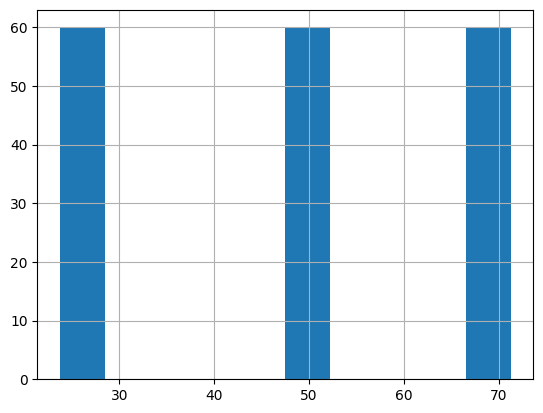

In [129]:
d['hand'].hist()

In [130]:
d['NS_hand'] = d['WTD']/np.sqrt(9500*9500/(1+1/(d['slope']/100)**2))

<Axes: >

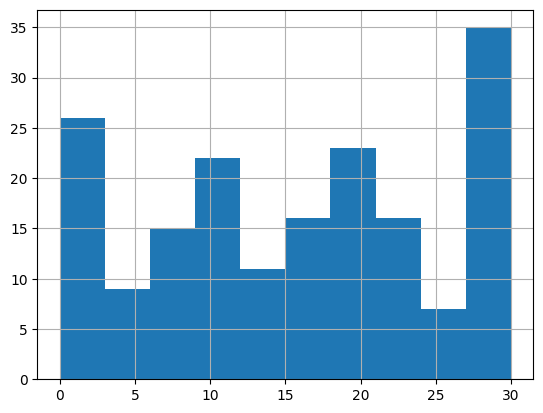

In [131]:
d['WTD'].hist()

<Axes: >

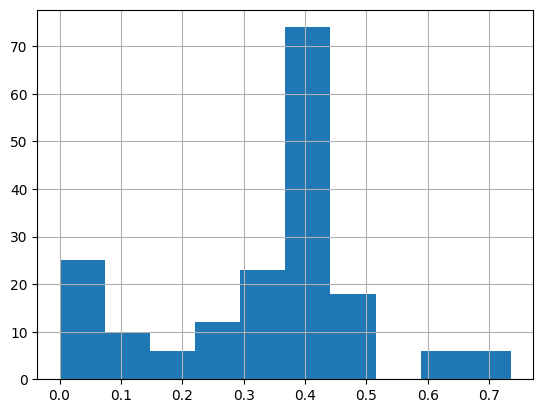

In [132]:
d['NS_hand'].hist()

In [133]:
DB = pd.read_csv('/home/hectorb/DATA/Aquifers/HardRock/processed_DB/buffer_capacity/Paper2024/Data_concat_QC_stor_aux_tmpdem.csv')
DB.set_index(DB.columns[0],inplace=True)

/tmp/ipykernel_13527/2206136012.py:1: DtypeWarning: Columns (3,4,5,6,7,8,9,10,21,28,29,30,31,32,33,34,35,36,37,39,40,41,43,56,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,90,91,93,96,105,107,108,109,112,137,152,156,157,166,167,172,173,174,175,177,180,188,189) have mixed types. Specify dtype option on import or set low_memory=False.
  DB = pd.read_csv('/home/hectorb/DATA/Aquifers/HardRock/processed_DB/buffer_capacity/Paper2024/Data_concat_QC_stor_aux_tmpdem.csv')


In [134]:
DB['hand2'] = DB['dem']-DB['dem_2_min']
DB['hand10'] = DB['dem']-DB['dem_10_min']
DB['hand50'] = DB['dem']-DB['dem_50_min']
DB['hand100'] = DB['dem']-DB['dem_100_min']
dist_un_degree_a_equateur = 111.3
DB['dem_100_dist_min_km'] = DB.dem_100_dist_min*dist_un_degree_a_equateur

DB['slope_NS_topo_diff_rel100'] =  DB['NS']/DB['hand100']
DB.loc[DB.slope_NS_topo_diff_rel100<=0,'slope_NS_topo_diff_rel100']  =np.nan 
DB.loc[DB.slope_NS_topo_diff_rel100>=2,'slope_NS_topo_diff_rel100']  =np.nan 


DB['slope_NS_topo_diff_rel50'] =  DB['NS']/DB['hand50']
DB.loc[DB.slope_NS_topo_diff_rel50<=0,'slope_NS_topo_diff_rel50']  =np.nan 
DB.loc[DB.slope_NS_topo_diff_rel50>=2,'slope_NS_topo_diff_rel50']  =np.nan 

DB['hand2_range'] = pd.cut(DB['hand2'], np.arange(0,12,2), labels=[str(i) for i in np.arange(0,10,2)+1]) # bin by P for all
DB['hand10_range'] = pd.cut(DB['hand10'], np.arange(0,42,2), labels=[str(i) for i in np.arange(0,40,2)+1]) # bin by P for all
DB['hand50_range'] = pd.cut(DB['hand50'], np.arange(0,62,2), labels=[str(i) for i in np.arange(0,60,2)+1]) # bin by P for all
DB['hand100_range'] = pd.cut(DB['hand100'], np.arange(0,82,2), labels=[str(i) for i in np.arange(0,80,2)+1]) # bin by P for all
DB['rech_range'] = pd.cut(DB['rech'], np.arange(0,160,10), labels=[str(i) for i in np.arange(0,150,10)+5]) # bin by P for all



<Axes: >

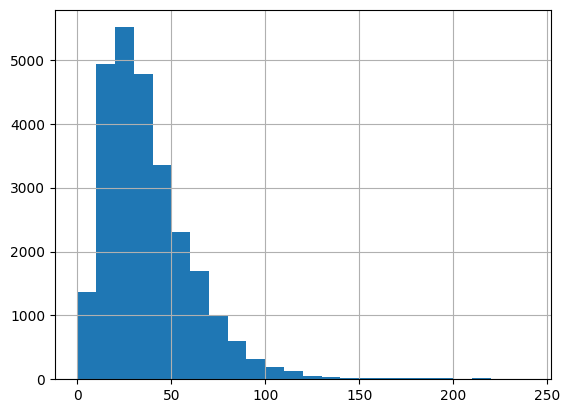

In [135]:
DB['hand100'].hist(bins=np.arange(0,250,10))

/tmp/ipykernel_13527/3014055569.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax[1],y='slope_NS_topo_diff_rel100', x='rech_range', data=DB,  palette='viridis', whis=[0, 2], width=0.6, showfliers=False)


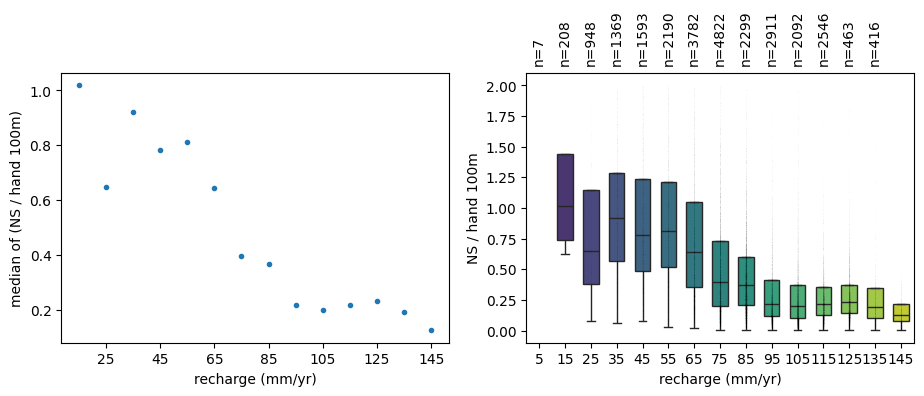

In [136]:
fig, ax= plt.subplots(1,2,figsize=(11,3.5))

DB.groupby('rech_range').slope_NS_topo_diff_rel100.median().plot(ax=ax[0],style='.')
ax[0].set_xlabel('recharge (mm/yr)')
ax[0].set_ylabel('median of (NS / hand 100m)')


sns.boxplot(ax=ax[1],y='slope_NS_topo_diff_rel100', x='rech_range', data=DB,  palette='viridis', whis=[0, 2], width=0.6, showfliers=False)
sns.swarmplot(ax=ax[1], y='slope_NS_topo_diff_rel100', x='rech_range', data=DB, color='k', alpha=0.6, size=0.1)
#ax[1].set_yscale('log')
ax[1].set_ylabel('NS / hand 100m')
ax[1].set_xlabel('recharge (mm/yr)')
categories = np.sort([int(i) for i in DB['rech_range'].unique().dropna()])

for ind,category in enumerate(categories):
    category = str(category)
    count = DB[DB['rech_range'] == category].shape[0]
    ax[1].annotate(f'n={count}', xy=(ind, 1.03), xycoords=('data', 'axes fraction'), ha='center', va='bottom',rotation=90)



/tmp/ipykernel_13527/644657689.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax[1],y='slope_NS_topo_diff_rel100', x='rech_range', data=DB_NS_inf1,  palette='viridis', whis=[0, 2], width=0.6, showfliers=False)


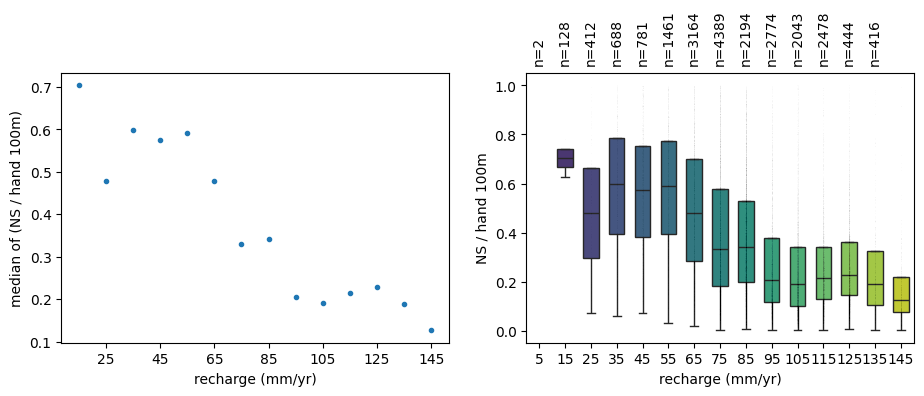

In [137]:
DB_NS_inf1 = DB.copy(deep=True).loc[DB.slope_NS_topo_diff_rel100<1,:]



fig, ax= plt.subplots(1,2,figsize=(11,3.5))

DB_NS_inf1.groupby('rech_range').slope_NS_topo_diff_rel100.median().plot(ax=ax[0],style='.')
ax[0].set_xlabel('recharge (mm/yr)')
ax[0].set_ylabel('median of (NS / hand 100m)')


sns.boxplot(ax=ax[1],y='slope_NS_topo_diff_rel100', x='rech_range', data=DB_NS_inf1,  palette='viridis', whis=[0, 2], width=0.6, showfliers=False)
sns.swarmplot(ax=ax[1], y='slope_NS_topo_diff_rel100', x='rech_range', data=DB_NS_inf1, color='k', alpha=0.6, size=0.1)
#ax[1].set_yscale('log')
ax[1].set_ylabel('NS / hand 100m')
ax[1].set_xlabel('recharge (mm/yr)')
categories = np.sort([int(i) for i in DB_NS_inf1['rech_range'].unique().dropna()])

for ind,category in enumerate(categories):
    category = str(category)
    count = DB_NS_inf1[DB_NS_inf1['rech_range'] == category].shape[0]
    ax[1].annotate(f'n={count}', xy=(ind, 1.03), xycoords=('data', 'axes fraction'), ha='center', va='bottom',rotation=90)



In [138]:
np.unique(d['Ks'],return_counts=True)

(array([4.00000000e-07, 1.00475457e-06, 2.52382938e-06, 6.33957277e-06,
        1.59242868e-05, 4.00000000e-05]),
 array([30, 30, 30, 30, 30, 30]))

In [139]:
DB.groupby('rech_range').slope_NS_topo_diff_rel100.median()

rech_range
5           NaN
15     1.017895
25     0.649251
35     0.920330
45     0.783090
55     0.813732
65     0.643776
75     0.397498
85     0.368702
95     0.218194
105    0.200000
115    0.218310
125    0.233907
135    0.194127
145    0.126222
Name: slope_NS_topo_diff_rel100, dtype: float64

In [140]:
DB_NS_inf1.groupby('rech_range').slope_NS_topo_diff_rel100.median()

rech_range
5           NaN
15     0.703713
25     0.478675
35     0.599059
45     0.574612
55     0.591197
65     0.479452
75     0.331144
85     0.341159
95     0.206097
105    0.190928
115    0.215190
125    0.227862
135    0.189673
145    0.126222
Name: slope_NS_topo_diff_rel100, dtype: float64

In [141]:
DB_NS_inf1['rech_range'] = DB_NS_inf1['rech_range'].apply(lambda x : float(x))

In [142]:
DBtmp =  DB_NS_inf1.groupby('rech_range').slope_NS_topo_diff_rel100.median()
DBtmp.index = [float(t) for t in DBtmp.index]
DBtmp.index

Float64Index([  5.0,  15.0,  25.0,  35.0,  45.0,  55.0,  65.0,  75.0,  85.0,
               95.0, 105.0, 115.0, 125.0, 135.0, 145.0],
             dtype='float64')

In [164]:
d['alpha'] = 6*d['surface_flux']

(0.01, 150.0)

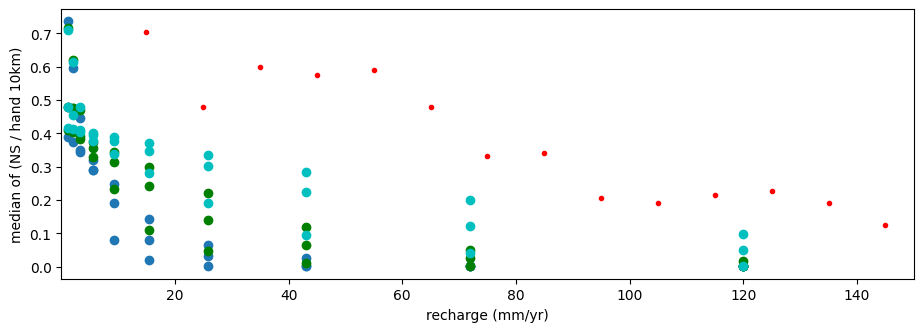

In [166]:
fig, ax= plt.subplots(figsize=(11,3.5))
DBtmp.plot(ax=ax,style='.',c='r')
dk0 = d.loc[d.Ks == np.unique(d['Ks'])[0],:]
dk1 = d.loc[d.Ks == np.unique(d['Ks'])[1],:]
dk2 = d.loc[d.Ks == np.unique(d['Ks'])[2],:]

#ax.scatter(x=dk0['surface_flux'],y=dk0['NS_hand'])
#ax.scatter(x=dk1['surface_flux'],y=dk1['NS_hand'],c='g')
#ax.scatter(x=dk2['surface_flux'],y=dk2['NS_hand'],c='c')

ax.scatter(x=dk0['alpha'],y=dk0['NS_hand'])
ax.scatter(x=dk1['alpha'],y=dk1['NS_hand'],c='g')
ax.scatter(x=dk2['alpha'],y=dk2['NS_hand'],c='c')

#np.set_printoptions(precision=2)
#sns.set(font_scale=2)
#splot = sns.relplot(x="surface_flux", y="NS_hand",hue='Ks', hue_norm=LogNorm(),size='slope',sizes=(50,500), data=d,height=7,aspect=3)
#splot = sns.relplot(x="surface_flux", y="NS_hand",hue='Ks', hue_norm=LogNorm(), data=d,height=7,aspect=3)
#splot = sns.relplot(ax=ax,x="surface_flux", y="NS_hand", data=d.loc[d.Ks == np.unique(d['Ks'])[1],:])

#splot.set(xscale="log")
#t = splot._legend.get_texts()
#splot.set(xlabel="surface flux (mm/yr)")
#splot.set(ylabel="NS/hand")
#%precision %2.2e
#t[0].set_text('Ks (m/s)')
"""
for i in range(4):
    t[i+1].set_text("{:.2e}".format(float(t[i+1].get_text())))
t[5].set_text('slope (%)')
for i in np.arange(6,11):
    t[i].set_text("{:.2}".format(float(t[i].get_text())))
"""
ax.set_xlabel('recharge (mm/yr)')
ax.set_ylabel('median of (NS / hand 10km)')

ax.set_xlim(0.01,150)

#ax.set_xscale('log')    
    

In [167]:
DBtmp2 = pd.DataFrame(DBtmp.copy(deep=True))

DBtmp2['rech_range'] = DBtmp2.index
DBtmp2=DBtmp2.dropna(how='any')
DBtmp2 =DBtmp2.set_index('slope_NS_topo_diff_rel100')

In [168]:
DBtmp2

rech_range
slope_NS_topo_diff_rel100            
0.703713                         15.0
0.478675                         25.0
0.599059                         35.0
0.574612                         45.0
0.591197                         55.0
0.479452                         65.0
0.331144                         75.0
0.341159                         85.0
0.206097                         95.0
0.190928                        105.0
0.215190                        115.0
0.227862                        125.0
0.189673                        135.0
0.126222                        145.0

In [169]:
dk0 = d.loc[d.Ks == np.unique(d['Ks'])[0],:]
dk1 = d.loc[d.Ks == np.unique(d['Ks'])[1],:]
dk2 = d.loc[d.Ks == np.unique(d['Ks'])[2],:]
dk3 = d.loc[d.Ks == np.unique(d['Ks'])[3],:]
dk4 = d.loc[d.Ks == np.unique(d['Ks'])[4],:]
dk5 = d.loc[d.Ks == np.unique(d['Ks'])[5],:]


(0.01, 150.0)

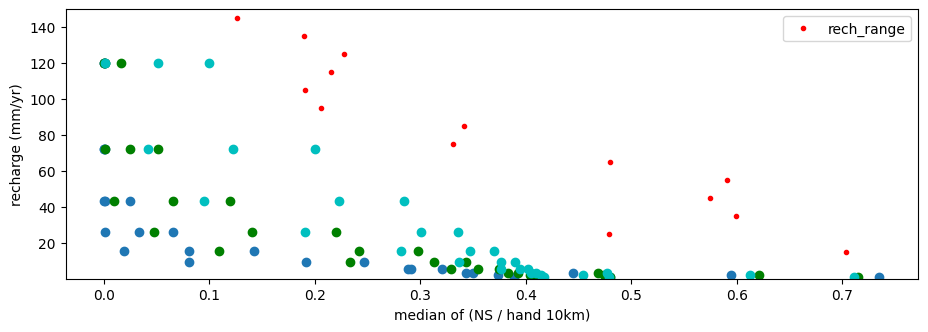

In [170]:
fig, ax= plt.subplots(figsize=(11,3.5))
DBtmp2.plot(ax=ax,style='.',c='r')


#ax.scatter(x=dk0['surface_flux'],y=dk0['NS_hand'])
#ax.scatter(x=dk1['surface_flux'],y=dk1['NS_hand'],c='g')
#ax.scatter(x=dk2['surface_flux'],y=dk2['NS_hand'],c='c')

ax.scatter(x=dk0['NS_hand'],y=dk0['alpha'])
ax.scatter(x=dk1['NS_hand'],y=dk1['alpha'],c='g')
ax.scatter(x=dk2['NS_hand'],y=dk2['alpha'],c='c')

#np.set_printoptions(precision=2)
#sns.set(font_scale=2)
#splot = sns.relplot(x="surface_flux", y="NS_hand",hue='Ks', hue_norm=LogNorm(),size='slope',sizes=(50,500), data=d,height=7,aspect=3)
#splot = sns.relplot(x="surface_flux", y="NS_hand",hue='Ks', hue_norm=LogNorm(), data=d,height=7,aspect=3)
#splot = sns.relplot(ax=ax,x="surface_flux", y="NS_hand", data=d.loc[d.Ks == np.unique(d['Ks'])[1],:])

#splot.set(xscale="log")
#t = splot._legend.get_texts()
#splot.set(xlabel="surface flux (mm/yr)")
#splot.set(ylabel="NS/hand")
#%precision %2.2e
#t[0].set_text('Ks (m/s)')
"""
for i in range(4):
    t[i+1].set_text("{:.2e}".format(float(t[i+1].get_text())))
t[5].set_text('slope (%)')
for i in np.arange(6,11):
    t[i].set_text("{:.2}".format(float(t[i].get_text())))
"""
ax.set_ylabel('recharge (mm/yr)')
ax.set_xlabel('median of (NS / hand 10km)')

ax.set_ylim(0.01,150)

#ax.set_xscale('log')    
    

In [148]:
DBtmp

5.0           NaN
15.0     0.703713
25.0     0.478675
35.0     0.599059
45.0     0.574612
55.0     0.591197
65.0     0.479452
75.0     0.331144
85.0     0.341159
95.0     0.206097
105.0    0.190928
115.0    0.215190
125.0    0.227862
135.0    0.189673
145.0    0.126222
Name: slope_NS_topo_diff_rel100, dtype: float64

In [149]:
tmp

slope_NS_topo_diff_rel100  rech_range
15.0                    0.703713        15.0
25.0                    0.478675        25.0
35.0                    0.599059        35.0
45.0                    0.574612        45.0
55.0                    0.591197        55.0
65.0                    0.479452        65.0
75.0                    0.331144        75.0
85.0                    0.341159        85.0
95.0                    0.206097        95.0
105.0                   0.190928       105.0
115.0                   0.215190       115.0
125.0                   0.227862       125.0
135.0                   0.189673       135.0
145.0                   0.126222       145.0

In [150]:
import statsmodels.api as sm
tmp = DB_NS_inf1.loc[:,['rech_range','slope_NS_topo_diff_rel100']]
tmp = tmp.dropna(how='any')
X = tmp['rech_range']
Y = tmp['slope_NS_topo_diff_rel100']
X = sm.add_constant(X)
fit = sm.OLS(Y, X).fit()
print(fit.summary())

                                OLS Regression Results                               
Dep. Variable:     slope_NS_topo_diff_rel100   R-squared:                       0.151
Model:                                   OLS   Adj. R-squared:                  0.151
Method:                        Least Squares   F-statistic:                     3808.
Date:                       Thu, 12 Sep 2024   Prob (F-statistic):               0.00
Time:                               12:45:25   Log-Likelihood:                 1622.2
No. Observations:                      21374   AIC:                            -3240.
Df Residuals:                          21372   BIC:                            -3224.
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

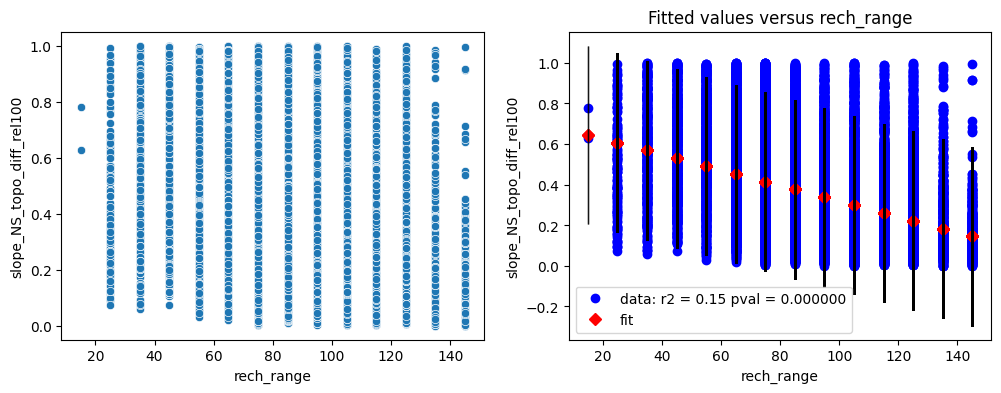

In [151]:
import seaborn as sns
fig, ax = plt.subplots(1,2,figsize=(12,4))
sns.scatterplot(x="rech_range", y="slope_NS_topo_diff_rel100", data=tmp,ax=ax[0])
sm.graphics.plot_fit(fit, 1, ax=ax[1])
ax[1].legend(['data: r2 = %2.2f pval = %f'%(fit.rsquared,fit.f_pvalue),'fit']) 

In [152]:
import statsmodels.api as sm
tmp = pd.DataFrame(DBtmp.copy(deep=True))
tmp['rech_range'] = tmp.index
tmp = tmp.dropna(how='any')
X = tmp['rech_range']
Y = tmp['slope_NS_topo_diff_rel100']
X = sm.add_constant(X)
fit = sm.OLS(Y, X).fit()
print(fit.summary())

                                OLS Regression Results                               
Dep. Variable:     slope_NS_topo_diff_rel100   R-squared:                       0.866
Model:                                   OLS   Adj. R-squared:                  0.855
Method:                        Least Squares   F-statistic:                     77.48
Date:                       Thu, 12 Sep 2024   Prob (F-statistic):           1.40e-06
Time:                               12:45:27   Log-Likelihood:                 17.877
No. Observations:                         14   AIC:                            -31.75
Df Residuals:                             12   BIC:                            -30.48
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

/home/hectorb/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


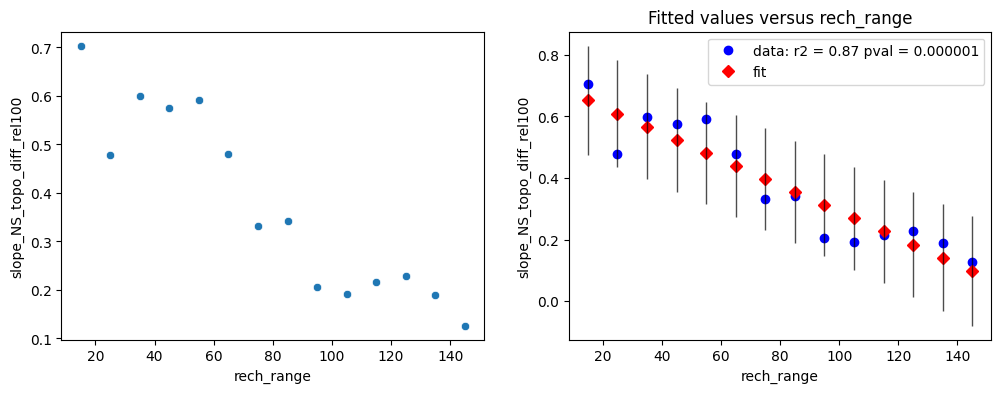

In [153]:
import seaborn as sns
fig, ax = plt.subplots(1,2,figsize=(12,4))
sns.scatterplot(x="rech_range", y="slope_NS_topo_diff_rel100", data=tmp,ax=ax[0])
sm.graphics.plot_fit(fit, 1, ax=ax[1])
ax[1].legend(['data: r2 = %2.2f pval = %f'%(fit.rsquared,fit.f_pvalue),'fit']) 

In [154]:
import statsmodels.api as sm
tmp = pd.DataFrame(DBtmp.copy(deep=True))
tmp['rech_range'] = tmp.index
tmp = tmp.dropna(how='any')
X = tmp['slope_NS_topo_diff_rel100']
Y = tmp['rech_range']
X = sm.add_constant(X)
fit = sm.OLS(Y, X).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:             rech_range   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     77.48
Date:                Thu, 12 Sep 2024   Prob (F-statistic):           1.40e-06
Time:                        12:45:27   Log-Likelihood:                -57.554
No. Observations:                  14   AIC:                             119.1
Df Residuals:                      12   BIC:                             120.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

/home/hectorb/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


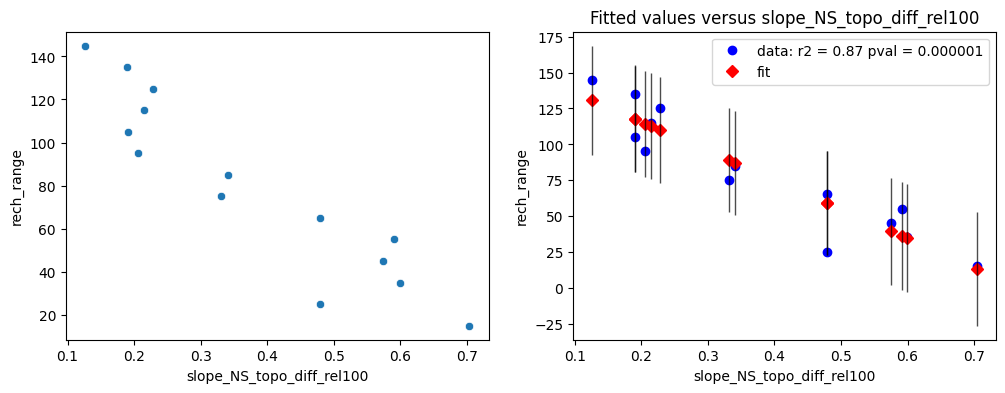

In [155]:
import seaborn as sns
fig, ax = plt.subplots(1,2,figsize=(12,4))
sns.scatterplot(x="slope_NS_topo_diff_rel100", y="rech_range", data=tmp,ax=ax[0])
sm.graphics.plot_fit(fit, 1, ax=ax[1])
ax[1].legend(['data: r2 = %2.2f pval = %f'%(fit.rsquared,fit.f_pvalue),'fit']) 

In [156]:
DBtmp

5.0           NaN
15.0     0.703713
25.0     0.478675
35.0     0.599059
45.0     0.574612
55.0     0.591197
65.0     0.479452
75.0     0.331144
85.0     0.341159
95.0     0.206097
105.0    0.190928
115.0    0.215190
125.0    0.227862
135.0    0.189673
145.0    0.126222
Name: slope_NS_topo_diff_rel100, dtype: float64

In [157]:
# Fit the linear model on DBtmp
tmp = pd.DataFrame(DBtmp.copy(deep=True))
tmp['rech_range'] = tmp.index
tmp = tmp.dropna(how='any')
print(tmp)
X_tmp = tmp['slope_NS_topo_diff_rel100']
Y_tmp = tmp['rech_range']
X_tmp = sm.add_constant(X_tmp)
fit_tmp = sm.OLS(Y_tmp, X_tmp).fit()

       slope_NS_topo_diff_rel100  rech_range
15.0                    0.703713        15.0
25.0                    0.478675        25.0
35.0                    0.599059        35.0
45.0                    0.574612        45.0
55.0                    0.591197        55.0
65.0                    0.479452        65.0
75.0                    0.331144        75.0
85.0                    0.341159        85.0
95.0                    0.206097        95.0
105.0                   0.190928       105.0
115.0                   0.215190       115.0
125.0                   0.227862       125.0
135.0                   0.189673       135.0
145.0                   0.126222       145.0


In [158]:
# Define the function that calculates the residual sum of squares (RSS)
def objective(alpha):
    # Apply scaling to surface_flux
    d_scaled = dk2['surface_flux'] * alpha

    #d_scaled= d_scaled.dropna(how='any')
    # Fit the linear model on d with scaled surface_flux
    X_d = dk2['NS_hand']
    Y_d_scaled = d_scaled
    X_d = sm.add_constant(X_d)
    fit_d = sm.OLS(Y_d_scaled, X_d).fit()

    # Calculate residuals between the slopes of the two fits (rech_range and scaled surface_flux)
    residuals = fit_tmp.params[1] - fit_d.params[1]
    return residuals**2  # Square the residuals to minimize


In [159]:
from scipy.optimize import minimize
# Use scipy's minimize function to find the optimal alpha
result = minimize(objective, x0=[10], method='Nelder-Mead')  # Initial guess for alpha is 1
optimal_alpha = result.x[0]
print(f'Optimal alpha: {optimal_alpha}')


Optimal alpha: 6.40521240234375
